# Reconstruction of plant--pollinator networks from observational data 

A tutorial on how to use our [Stan](http://mc-stan.org) model to infer the structure and properties of real ecosystems from noisy, error-prone measurements.
Based on the article [*"Reconstruction of plant--pollinator networks from observational data"*](https://www.biorxiv.org/content/10.1101/754077v1), by [J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).


*Author*: J.-G. Young <jgyou@umich.edu> <br/>
*Date*: July 2019

---

**Important Note:** In this notebook, I assume that you have installed `pystan` and will interact with the model in `python3` (check the [README](README.md) file otherwise). `Stan` also has a [R interface](https://cran.r-project.org/web/packages/rstan/index.html), for which we do not provide helper functions.
That said, all what we show here should easily be transferable to the `R` version of `Stan`!
The only purpose of our python code is to manipulate the samples once they have been generated by `Stan`.

---

## Loading data and modules

First, let's import some required modules: 'pystan `numpy` and `pyplot` to handle the model the data and visualize our results.
We'll also import the custom helper modules `utilities` (load / save / compress / sort data matrices) and `plant_pol_inference` (interact with model, draw samples, compute estimates).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
import utilities as ut
import plant_pol_inference as pp
import nest_asyncio
nest_asyncio.apply()
del nest_asyncio
import stan_jupyter as stan

We'll use the data matrix shown in the paper as an example. 
It comes from the Supplementary information of [this paper by Kaiser-Bunbury et al. [Nature **542**, 2017]](https://www.nature.com/articles/nature21071). It records the number of interactions between 8 plant species and 21 pollinator species. This is for a single ecosystem, as observed over the course of one month.

In [2]:
M = np.loadtxt('example_matrix.txt').astype('int')
M = ut.sort(M, M)
n_p = M.shape[0]
n_a = M.shape[1]

Let's visualize it:

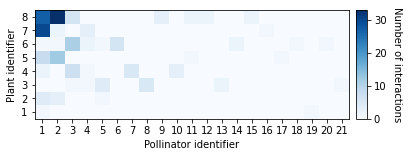

In [3]:
plt.figure(figsize=(6,2))
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');

## Pystan model

In `pystan`, we write the statistical model in a separate file.
In our case, it looks like:

In [4]:
with open('model.stan', 'r') as f:
    print(f.read())

data {
  // Dimensions of the data matrix, and matrix itself.
  int<lower=1> n_p;
  int<lower=1> n_a;
  int<lower=0> M[n_p, n_a];
}
transformed data {
  // Pre-compute the marginals of M to save computation in the model loop.
  int M_rows[n_p] = rep_array(0, n_p);
  int M_cols[n_a] = rep_array(0, n_a);
  int M_tot = 0;
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      M_rows[i] += M[i, j];
      M_cols[j] += M[i, j];
      M_tot += M[i, j];
    }
  }
}
parameters {
  real<lower=0> C;
  real<lower=0> r;
  simplex[n_p] sigma;
  simplex[n_a] tau;
  real<lower=0, upper=1> rho;
}
model {
  // Global sums and parameters
  target += M_tot * log(C) - C;
  // Weighted marginals of the data matrix 
  for (i in 1:n_p) {
    target += M_rows[i] * log(sigma[i]);
  }
  for (j in 1:n_a) {
    target += M_cols[j] * log(tau[j]);
  }
  // Pairwise loop
  for (i in 1:n_p) {
    for (j in 1:n_a) {
      real nu_ij_0 = log(1 - rho);
      real nu_ij_1 = log(rho) + M[i,j] * log(1 + r) - C * r * sigma[i] * t

The `data` block contains the model parameters, in our case the dimension of the observation matrix, and the matrix itself.

The `transformed data` block allows us to calculate quantities that we'll use later. Here, we calculate the row and column sums of M, as well as its total sum.

The `parameter` block contains... well.. the parameters of the model.
These parameters are the ones that will be sampled by `Stan`, and returned to us  once we run the program.
`sigma` and `tau` are of the "simplex" type---just a synonym for normalized distributions.

The `model` block calculates the log-posterior of the model. We accumulate this value in the variable `target`.

The `generated quantities` block contains other quantities, functions of the sampled parameters, that will be returned to us once we run the program. In this case, we generate the matrix Q of edge probabilities given the parameters.

---

## Compiling the model

To  start using the model, we first need to "compile" it.
During compilation, `pystan` builds an executable whose purpose is to generate samples from our model, given an input.
Compilation takes a bit of time, but we only need to compile the model once. We are free to re-use it as many times as we like afterwards.

Our module `plant_pol_inference` (imported as `pp`) provides utilities to handle this.

In [5]:
model = pp.compile_stan_model(M)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_u9rs_4md/model_pjpuicrq.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_u9rs_4md/model_pjpuicrq.stan', line 9, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_u9rs_4md/model_pjpuicrq.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will 

[Compiling]


## Sampling

With the model compiled, we are ready to generate our first samples.

Our `plant_pol_inference` module also provide utilities that handle this.

In [6]:
samples = pp.generate_sample(model, warmup=2000, num_samples=500)

Sampling:   0%
Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   4% (400/10000)
Sampling:   6% (600/10000)
Sampling:   8% (800/10000)
Sampling:  10% (1000/10000)
Sampling:  11% (1100/10000)
Sampling:  14% (1400/10000)
Sampling:  16% (1600/10000)
Sampling:  18% (1800/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  24% (2400/10000)
Sampling:  26% (2600/10000)
Sampling:  28% (2800/10000)
Sampling:  31% (3100/10000)
Sampling:  34% (3400/10000)
Sampling:  37% (3700/10000)
Sampling:  38% (3800/10000)
Sampling:  41% (4100/10000)
Sampling:  45% (4500/10000)
Sampling:  47% (4700/10000)
Sampling:  49% (4900/10000)
Sampling:  52% (5200/10000)
Sampling:  55% (5500/10000)
Sampling:  58% (5800/10000)
Sampling:  60% (6000/10000)
Sampling:  68% (6800/10000)
Sampling:  75% (7500/10000)
Sampling:  85% (8500/10000)
Sampling: 100% (10000/1

The warnings above indicate that at least one chain has gotten stuck in a minima.

We can see this by plotting the value of the posterior distribution, evaluated for each samples.

Note that in this plot, vertical lines separate Markov chains: All samples between two of these lines are generated sequentially, by an independent chain.

Text(0, 0.5, 'log posterior')

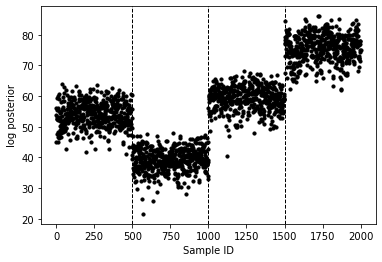

In [7]:
# re-sort data so that it can be easiliy visualized by chain
chains = [1, 2, 3, 4] * 500
log_probs = np.column_stack((chains, samples['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(2000), log_probs[:,1], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')

In this particular case, two chains have gotten stuck in an optima with lower posterior probability.

We'll re-run the sampling until we get a clean sample:

In [8]:
while not pp.test_samples(samples, tol=0.05):
    model = pp.compile_stan_model(M)
    samples = pp.generate_sample(model, warmup=2000, num_samples=500)

Building: found in cache, done.
Messages from stanc:
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_u9rs_4md/model_pjpuicrq.stan', line 5, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_u9rs_4md/model_pjpuicrq.stan', line 9, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/var/folders/dz/887wb7q155d3pyd6qzhg8hrm0000gn/T/httpstan_u9rs_4md/model_pjpuicrq.stan', line 10, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will 

[54.04148366 39.15408047 59.94133428 76.5358813 ]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   4% (401/10000)
Sampling:   7% (701/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  12% (1200/10000)
Sampling:  15% (1500/10000)
Sampling:  17% (1700/10000)
Sampling:  18% (1800/10000)
Sampling:  20% (2000/10000)
Sampling:  23% (2300/10000)
Sampling:  24% (2400/10000)
Sampling:  26% (2600/10000)
Sampling:  28% (2800/10000)
Sampling:  31% (3100/10000)
Sampling:  33% (3300/10000)
Sampling:  35% (3500/10000)
Sampling:  38% (3800/10000)
Sampling:  42% (4200/10000)
Sampling:  44% (4400/10000)
Sampling:  45% (4500/10000)
Sampling:  48% (4800/10000)
Sampling:  56% (5600/10000)
Sampling:  60% (6000/10000)
Sampling:  65% (6500/10000)
Sampling:  75% (7500/10000)
Sampling:  88% (8800/10000)
Sampling: 100% (10000/10000)
Sampling: 100% (10000/10000), done.
Messages received during sampling:
  Gradient evaluation 

[76.6442761  38.5660449  75.23111811 76.35095311]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (301/10000)
Sampling:   5% (501/10000)
Sampling:   6% (600/10000)
Sampling:   8% (800/10000)
Sampling:   9% (900/10000)
Sampling:  12% (1200/10000)
Sampling:  14% (1400/10000)
Sampling:  16% (1600/10000)
Sampling:  18% (1800/10000)
Sampling:  21% (2100/10000)
Sampling:  22% (2200/10000)
Sampling:  25% (2500/10000)
Sampling:  26% (2600/10000)
Sampling:  29% (2900/10000)
Sampling:  31% (3100/10000)
Sampling:  33% (3300/10000)
Sampling:  35% (3500/10000)
Sampling:  39% (3900/10000)
Sampling:  41% (4100/10000)
Sampling:  44% (4400/10000)
Sampling:  46% (4600/10000)
Sampling:  49% (4900/10000)
Sampling:  53% (5300/10000)
Sampling:  65% (6500/10000)
Sampling:  73% (7300/10000)
Sampling:  79% (7900/10000)
Sampling:  84% (8400/10000)
Sampling:  85% (8500/10000)
Sampling:  86% (8600/10000)
Sampling:  87% (8700/10000)
Sampling:  

[39.53120755 75.85317112 58.29207388 77.33048003]
[Compiling]


Sampling:   0% (1/10000)
Sampling:   0% (2/10000)
Sampling:   0% (3/10000)
Sampling:   0% (4/10000)
Sampling:   1% (103/10000)
Sampling:   2% (202/10000)
Sampling:   3% (302/10000)
Sampling:   5% (501/10000)
Sampling:   6% (600/10000)
Sampling:   7% (700/10000)
Sampling:   9% (900/10000)
Sampling:  10% (1000/10000)
Sampling:  12% (1200/10000)
Sampling:  13% (1300/10000)
Sampling:  15% (1500/10000)
Sampling:  16% (1600/10000)
Sampling:  17% (1700/10000)
Sampling:  19% (1900/10000)
Sampling:  21% (2100/10000)
Sampling:  23% (2300/10000)
Sampling:  25% (2500/10000)
Sampling:  26% (2600/10000)
Sampling:  27% (2700/10000)
Sampling:  29% (2900/10000)
Sampling:  30% (3000/10000)
Sampling:  32% (3200/10000)
Sampling:  33% (3300/10000)
Sampling:  34% (3400/10000)
Sampling:  36% (3600/10000)
Sampling:  38% (3800/10000)
Sampling:  39% (3900/10000)
Sampling:  41% (4100/10000)
Sampling:  43% (4300/10000)
Sampling:  45% (4500/10000)
Sampling:  46% (4600/10000)
Sampling:  48% (4800/10000)
Sampling:  

[76.90142205 76.70760491 76.95178139 76.89499357]


After a few attempt we find a nice set of samples:

Text(0, 0.5, 'log posterior')

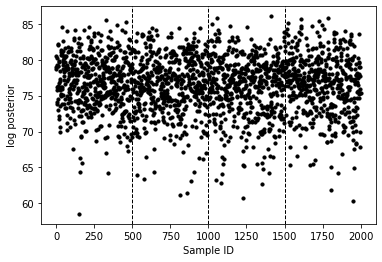

In [9]:
# re-sort data so that it can be easiliy visualized by chain
chains = [1, 2, 3, 4] * 500
log_probs = np.column_stack((chains, samples['lp__'][0]))
log_probs = log_probs[log_probs[:,0].argsort()]

# plot it
plt.scatter(range(2000), log_probs[:,1], s=10, c='k')
for sep in [500, 1000, 1500]:
    plt.axvline(sep, c='k', ls='--', lw=1)
plt.xlabel('Sample ID')
plt.ylabel('log posterior')

Here's the summary of our succesful sampling procedure:

In [10]:
samples.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,C,r,sigma.1,...,Q.7.20,Q.8.20,Q.1.21,Q.2.21,Q.3.21,Q.4.21,Q.5.21,Q.6.21,Q.7.21,Q.8.21
draws,,,,,,,,,,,,,,,,,,,,,
0,78.668885,0.977942,0.150029,5.0,31.0,0.0,-63.577980,23.369150,32.630089,0.028143,...,0.204174,0.191153,0.127670,0.161203,0.324651,7.516034e-03,0.068341,1.445821e-04,0.023839,0.003267
1,79.571664,0.998116,0.130986,5.0,31.0,0.0,-65.702302,12.432976,45.004617,0.032673,...,0.050553,0.049997,0.228436,0.225671,0.795869,6.438925e-02,0.168603,1.036214e-01,0.021651,0.021305
2,80.711859,0.941191,0.129622,4.0,15.0,0.0,-69.336674,26.984897,35.904200,0.109764,...,0.088269,0.085367,0.113817,0.194290,0.856569,9.053438e-02,0.132401,5.358021e-02,0.081798,0.078872
3,75.401605,0.985882,0.150266,5.0,31.0,0.0,-60.633367,18.659398,30.203163,0.035146,...,0.177397,0.173701,0.220604,0.226836,0.739174,9.755754e-02,0.204439,4.757623e-02,0.097309,0.092400
4,69.657691,0.917630,0.150029,4.0,15.0,0.0,-55.759751,27.787639,31.686494,0.051446,...,0.162647,0.157029,0.058666,0.114221,0.221134,4.106805e-03,0.061398,1.734416e-04,0.019973,0.003918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,76.306142,0.977022,0.150266,4.0,15.0,0.0,-63.884693,16.193949,38.143852,0.033342,...,0.143026,0.152038,0.260106,0.301924,0.883671,1.115890e-01,0.237137,2.990859e-02,0.034145,0.040233
1996,75.733264,0.817566,0.150029,5.0,31.0,0.0,-56.688490,18.134277,31.519960,0.024392,...,0.000135,0.001197,0.222831,0.227454,0.837531,1.828620e-01,0.203136,1.626919e-01,0.127771,0.153120
1997,81.845036,0.998265,0.130986,4.0,31.0,0.0,-68.971136,22.075406,33.198668,0.015967,...,0.083316,0.094522,0.196108,0.215386,0.819061,4.173692e-02,0.110923,2.966760e-03,0.019490,0.026461


It shows that we can safely ignore the `Rhat` warning, because, as we see, the warning is triggered by the fact that all the samples agree on some entries of the matrix Q.

For example, Q[7,1], is always equal to 1. That is, there is such a strong evidence for the link (7,1) that all samples place an edge between these two nodes. `stan` does not see any variances and  throws a warning. In our case this is by design. 

To see this, let's inspect the entry of the data matrix corresponding to this node pair:

(*Note*: `stan` indices start from 1 not 0. Hence Q[7,1] is associated with M[6,0])

In [11]:
M[6,0]

30

Indeed, we see that there were 30 observations for this entry---no wonder the samples all place an edge between these nodes!

We now have well-behaved samples, let's move on to model checking and estimation.

## Posterior-predictive check

We provide a simple function that calculates the posterior predictive matrix.

In [12]:
M_tilde = pp.get_posterior_predictive_matrix(samples)

Let's compare it with the input

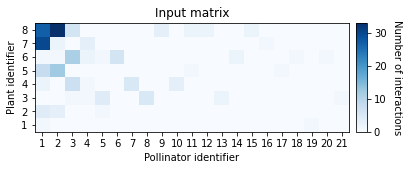

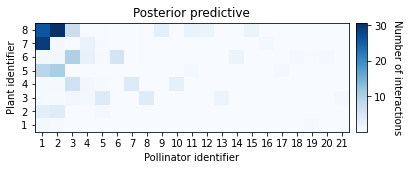

In [13]:
plt.figure(figsize=(6,2))
plt.title('Input matrix')
plt.pcolormesh(M, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');
plt.figure(figsize=(6,2))
plt.title('Posterior predictive')
plt.pcolormesh(M_tilde, cmap=plt.cm.Blues)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Number of interactions', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


They are quite close!

More systematically we can check the distribution of the differences between the posterior predictive and the input:

Text(0, 0.5, 'Count')

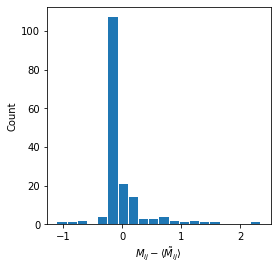

In [14]:
plt.figure(figsize=(4,4))
plt.hist((M-M_tilde).flatten(), density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$M_{ij}-\langle \tilde{M}_{ij}\rangle$')
plt.ylabel('Count')

Or compare the posterior predictive value to the input directly:

(-4.9, 38.0)

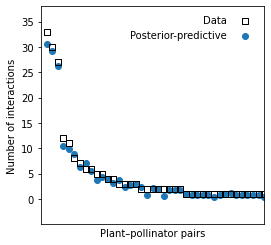

In [15]:
plt.figure(figsize=(4,4))
sort_order = np.argsort(-M.flatten())

plt.scatter(range(1, len(sort_order)+1), M.flatten()[sort_order], marker='s', facecolors='none', edgecolors='k', label='Data')
plt.scatter(range(1, len(sort_order)+1), M_tilde.flatten()[sort_order], label='Posterior-predictive', zorder=-10)

plt.xlim(0,40)
plt.xlabel('Plant–pollinator pairs')
plt.xticks([])
plt.ylabel(r'Number of interactions')
plt.legend(frameon=False, markerfirst=False, loc=1)
plt.ylim(-4.9,38)

All these point of view confirm one thing: The model fits well.

Which means we're ready to calculate some estimates.

## Estimates

We provide a simple function to get the network estimate:

In [16]:
edge_prob = pp.estimate_network(samples)

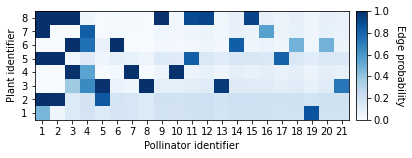

In [17]:
plt.figure(figsize=(6,2))

plt.pcolormesh(edge_prob, cmap=plt.cm.Blues, vmin=0, vmax=1)
cb= plt.colorbar(fraction=0.04, pad=0.02, aspect=10)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Edge probability', rotation=270)
plt.yticks(np.array(range(n_p)) + 0.5, range(1, n_p + 1))
plt.xticks(np.array(range(n_a)) + 0.5, range(1, n_a + 1))
plt.xlabel('Pollinator identifier');
plt.ylabel('Plant identifier');


In [18]:
Q = samples['Q'].transpose((2, 0, 1))
enumerate(Q)

The parameters themselves are contained in the `samples` object:

In [19]:
samples['rho']

array([[0.22095089, 0.30830426, 0.21059885, ..., 0.23304102, 0.12555818,
        0.26545665]])

So we can, for example, visualize posterior distributions as:

Text(0, 0.5, 'Count')

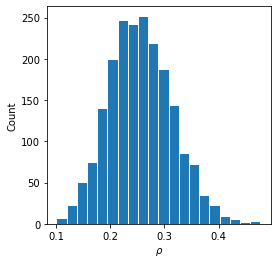

In [20]:
plt.figure(figsize=(4,4))
plt.hist(samples['rho'][0], density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\rho$')
plt.ylabel('Count')

And find posterior averages with:

In [21]:
print('Posterior average of the connectance:', np.mean(samples['rho'][0], axis=0))

Posterior average of the connectance: 0.25629762829853053


The same thing goes for, say, the plant abundances (now a dimension `samples * n_p` object---hence why we average along the axis 0, the `samples` axis):

In [22]:
mean_sigma = np.mean(samples['sigma'], axis=1)

Text(0, 0.5, 'Effective abundance')

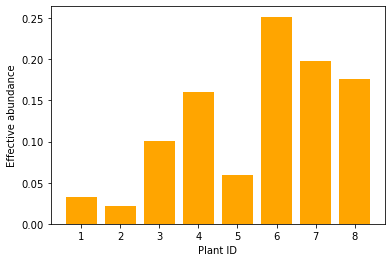

In [23]:
plt.bar([i + 1 for i in range(n_p)], mean_sigma, color='orange')
plt.xlabel('Plant ID')
plt.ylabel('Effective abundance')

We can do the same with the pollinators:

In [24]:
mean_tau = np.mean(samples['tau'], axis=1)

Text(0, 0.5, 'Effective abundance')

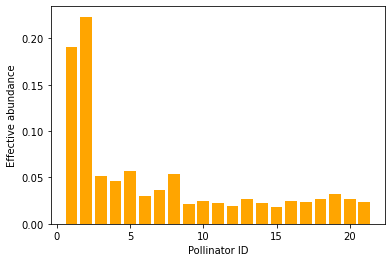

In [25]:
plt.bar([i + 1 for i in range(n_a)], mean_tau, color='orange')
plt.xlabel('Pollinator ID')
plt.ylabel('Effective abundance')

The last thing we'll calculate is the posterior distribution of **some arbitrary function** of the incidence matrix.

To make this example simple, we'll consider the number of non-zero entries, i.e.,

$$f(B) = \sum_{ij} B_{ij}$$

The python definition of this function is simple:

In [26]:
def edge_sum(B):
    return np.sum(B)

Again, we provide a simpler interface to make the calculation:

In [27]:
posterior_values_edge_sum = pp.get_network_property_distribution(samples, edge_sum)

We find, in this case:

Text(0, 0.5, 'Count')

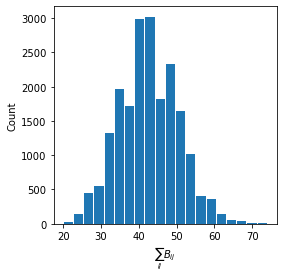

In [28]:
plt.figure(figsize=(4,4))
plt.hist(posterior_values_edge_sum, density=False, bins=20, rwidth=0.9);

plt.xlabel(r'$\sum_{ij} B_{ij}$')
plt.ylabel('Count')

# Further information: 

"*[Reconstruction of plant–pollinator networks from observational data](https://www.biorxiv.org/content/10.1101/754077v1)*"<br/>
[J.-G. Young](http://jgyoung.ca), [F. S. Valdovinos](https://www.fsvaldovinos.com/) and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/)<br/>
bioRxiv:754077 (2019)


Or get in touch at <jgyou@umich.edu> and on [github](https://github.com/jg-you/plant-pol-inference)!